Schuller et al., eIF5A Functions Globally in Translation Elongation and Termination, Molecular Cell (2017), http:// dx.doi.org/10.1016/j.molcel.2017.03.003

Polarity at position i in gene with length l is defined as:

$w_i = {{2i-(l+1)}\over{l - 1}}$

$p_i = {{d_i w_i}\over{\sum_{i=1}^l d_i}}$

In [1]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
d1 = 0
d2 = 35000000
num_c = 10
m1 = 1200
m2 = 1500
viewer = 2000
exclude = 0
cwd = os.getcwd()
print(cwd)
# Ribosome counts directory
Ribocsv_dir = cwd+'/output/Glu_readd/EY-Ribo/'
#Ribocsv_dir = cwd+'/output/Anna/'
#polcsv_dir = cwd+'/outputcsv/Anna/'
polcsv_dir = cwd+'/outputcsv/Glu_readd/EY-Ribo/'
# mRNA counts directory
#RNAcsv_dir = cwd+'/output/Glu_readd/EY-RNA/'
# Delta Dhh1 file
dhh1file = cwd+'/Dhh1_Length_Short.xlsx'
# Mitochondia genes
mitofile = cwd+'/Williams_mito_Proxi_ribosom_Profiling.xls'
#tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
tag = 'Ribo'
#names = ['811','813', '815','817']
#labels = ['logphase', '-Glucose 1min','-Glucose 5min', '-Glucose 15min']
#names = ['15','7516','1517', '15118','15529']
names = ['15','7516','1517']
labels = ['logphase','-Glucose 7.5min', '-Glucose 15min']

# Range of genes: length in bp
d1 = 0
d2 = 7654321
startbp = 45
endbp = 2000
# Dhh1 tag all, enriched, depleted
dhh1_tag = 'all'

/Users/jiz225/Desktop/ZidLab/polarity


In [3]:
codes = ['HSP30','PAB1','PGK1','HSP82','HXK1','GLC3']
col = ['red','green','green','red','blue','blue']
red = ['YCR021C','YER165W','YCR012W','YPL240C','YFR053C','YEL011W']

In [4]:
## Load data and find concensus genes in length range
#red = ['YLL026W', 'YDR258C', 'YPL240C', 'YBR169C', 'YER103W', 'YGR142W', 'YDR171W', 'YCR021C', 'YBR072W', 'YFL014W', 'YLR327C']
isred = []
df_dhh1_all = pd.read_excel(dhh1file)
df_dhh1_all = df_dhh1_all.set_index('Name')
namelist = df_dhh1_all.index
polcsv_list = []
for root,dirs,files in os.walk(polcsv_dir):
    for n in names:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split(tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                polcsv_list.append(polcsv_dir + file)
                df = pd.read_csv(polcsv_dir + file)
                #d2 = min(d2, max(df.Length))
                df = df[(df.Length >= d1)&(df.Length <= d2)]
                namelist = list(set(namelist) & set(df.Name))
print('all files to measure in ' + Ribocsv_dir + ' is ',len(polcsv_list))
df_dhh1 = df_dhh1_all[df_dhh1_all.index.isin(namelist)] 
print('total number of genes: ', len(df_dhh1))
spread_dhh1 = df_dhh1.Delta_Dhh1.quantile([0.25,0.5,0.65,0.75])
print(spread_dhh1)
low = spread_dhh1.get(key=0.25)
med = spread_dhh1.get(key=0.5)
high = spread_dhh1.get(key=0.75)

dhh1_enrich = df_dhh1[(df_dhh1.Delta_Dhh1 > med)]
dhh1_deplet = df_dhh1[(df_dhh1.Delta_Dhh1 < med)]
#dhh1_all = df_dhh1[(df_dhh1.Delta_Dhh1 > low)&(df_dhh1.Delta_Dhh1 < high)]
dhh1_all = df_dhh1
print('dhh1 enriched genes(-G-+G) ',len(dhh1_enrich))
print('dhh1 depleted genes(-G-+G) ',len(dhh1_deplet))
print('dhh1 all genes(-G-+G) ',len(dhh1_all))

if dhh1_tag == 'enriched':
    namelist = dhh1_enrich.index.tolist()
if dhh1_tag == 'depleted':
    namelist = dhh1_deplet.index.tolist()
if dhh1_tag == 'all':
    namelist = df_dhh1.index.tolist()

print(dhh1_tag, len(namelist))

15
7516
1517
all files to measure in /Users/jiz225/Desktop/ZidLab/polarity/output/Glu_readd/EY-Ribo/ is  3
total number of genes:  4319
0.25   -0.409515
0.50    0.127641
0.65    0.406414
0.75    0.592998
Name: Delta_Dhh1, dtype: float64
dhh1 enriched genes(-G-+G)  2159
dhh1 depleted genes(-G-+G)  2159
dhh1 all genes(-G-+G)  4319
all 4319


In [ ]:
'''
Description: Parse the input file to start at 15 bps upstream of each gene
    Input: path for input file and path for new csv file generated
'''
def makecsv(inputpath, outputpath, ext):
    inputf = open(inputpath,'r')
    outputf = open(outputpath, 'w')
    print(outputpath)
    outputf.write('Name'+ ',' + 'Orient' + ',' + 'Start' + ',' + 'End' + ',' + 'Position' + ',' +'Length' + ',' + 'RelativePosition' + ',' + 'Counts' + '\n')
    rposit = -1000    
    lines = inputf.readlines()
    for line in lines:
        string = line.rstrip() 
        cells = string.split('\t')
        name = cells[0][:7] 
        orient = cells[0][6:7]
        start = cells[1]
        end = cells[2]
        length = abs(int(start) - int(end))
        riboCount = cells[4]
        posit = cells[3]
        
        if orient == 'W':
            rposit = (int(cells[3])+1 - (int(start)))
    
        elif orient == "C":
            rposit = ((int(start))-(int(cells[3])-1))
            
        #if rposit > 0 and rposit <(length-15):
        if rposit <(length-15):
            outputf.write(str(name) + ',' + str(orient) + ',' + str(start) + ',' + str(end) + ',' + str(posit) + ',' + str(length-15) + ',' + str(rposit) + ',' + str(riboCount) + '\n')
    inputf.close()
    outputf.close()

In [ ]:
def calculatePolarity(i, l, densityati, density):
    normDist = (2*i - (l + 1))/(l - 1)   
    polarity = densityati*normDist/density
    
    return polarity

def PolarityPerGene(inputpath, destdir):
    df = pd.read_csv(inputpath)
    df = df[(df.RelativePosition > 0)]
    names = inputpath.split('.')
    names1 = names[0].split('/')
    
    #this is the final output file
    nameofcsv = destdir + names1[len(names1) - 1] + str("_polarity&gene.csv")
    print(nameofcsv)
    
    len_dict = dict(zip(df['Name'],df['Length']))
    den_dict = df.groupby('Name')['Counts'].agg('sum').to_dict()
    
    Polaritylist = []
    for i in range (len(df)):
        polarityofi = calculatePolarity(df.iloc[i,6], df.iloc[i,5], df.iloc[i,7], den_dict.get(df.iloc[i,0]))
        Polaritylist.append(polarityofi)
    df['Polarity'] = Polaritylist
    
    #calculate polarity per gene
    pol_dict = df.groupby('Name')['Polarity'].agg('sum').to_dict()
    #print(pol_dict)
    Lengthlist = []
    Totalcountlist = []
    names = []
    genepol = []
    for name in pol_dict.keys():
        if name in len_dict.keys() and name in den_dict.keys():
            Lengthlist.append(len_dict.get(name))
            Totalcountlist.append(den_dict.get(name))
            names.append(name)
            genepol.append(pol_dict.get(name))
        
    d = {'Name':names,'Length':Lengthlist,'Counts':Totalcountlist,'PolarityPerGene': genepol}
    dfcsv = pd.DataFrame(data=d)
    dfcsv = dfcsv.dropna(how='any',axis=0)
    dfcsv.to_csv(nameofcsv)
   

In [ ]:
inputlist = []
outputlist = []
inputfolder = os.listdir(inpath)
extension = "*.xls"
for doc in inputfolder:
    if fnmatch.fnmatch(doc, extension):
        #change this input and ouput file path
        inputpath = inpath + doc
        namelist = doc.split('.')
        name = namelist[0]
        outputpath = Ribocsv_dir + name + str(".csv")
        inputlist.append(inputpath)
        outputlist.append(outputpath)
print('\n Number of possible input files: ' + str(len(inputlist)))
print('\n Number of possible output csv files: ' + str(len(outputlist)))
    
for i in range(0, len(inputlist)):
    makecsv(inputlist[i], outputlist[i], extension)
    PolarityPerGene(outputlist[i], pol_dir)
    #break

In [ ]:
polcsv_list = []
tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
for root,dirs,files in os.walk(pol_dir):
    for file in files:
        if file.split('.')[-1] == "csv" and tag in file:
            polcsv_list.append(csv_dir + file)
polcsv_list = sorted(polcsv_list)
print(len(csv_list_s))
print(csv_list_s)

In [6]:
keys = []
values_list = []
fit_list = []
times = []
llist = []
df_samples = pd.DataFrame()
num_c = 15
for i in range(len(polcsv_list)):
    file = polcsv_list[i]
    time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split('.csv')[0])) 
    label = labels[names.index(time)]
    print(label)
    times.append(label)
    df = pd.read_csv(file)
    df = df[(df.Name.isin(namelist))]
    '''
    df = df.set_index('Name')
    df_l = df.loc[:,'Length']
    df = df.rename(columns={"PolarityPerGene": label})  
    df = df.loc[:,label]
    if len(df_samples) == 0:
        df_samples = df_l
    
    df_samples = pd.merge(df_samples,df,left_index=True, right_index=True)
    
    '''
    rbf_dict = df.groupby(['Length']).agg({"PolarityPerGene": np.sum, "Name": pd.Series.nunique})
    rbf_dict['AveragedPolarity'] = rbf_dict['PolarityPerGene']/rbf_dict['Name']
    print('In sample ', time, ' number of genes used ', len(df))
    rbf_dict = rbf_dict.sort_values(by=['Length'])
    pol = 0
    agg_dict = dict()
    for c in rbf_dict.index:
        left_c = max(1,c - int(num_c*3/2))
        right_c = c + int(num_c*3/2) + 1
        pol = rbf_dict.loc[left_c:right_c,'PolarityPerGene'].mean(axis=0) 
        agg_dict.update({c:pol})
        pol = 0
    
    temp_df = pd.DataFrame.from_dict(data = {'Length': list(agg_dict.keys()), label: list(agg_dict.values())})
    temp_df = temp_df.set_index('Length')
    if len(df_samples) == 0: 
        df_samples = temp_df  
    else:
        #print(df_samples.columns)
        df_samples = pd.merge(df_samples, temp_df, left_index=True, right_index=True)
        
    
    
#df_samples = df_samples.sort_values(by=['Length'])

logphase
In sample  811  number of genes used  2624
-Glucose 1min
In sample  813  number of genes used  2624
-Glucose 5min
In sample  815  number of genes used  2624
-Glucose 15min
In sample  817  number of genes used  2624


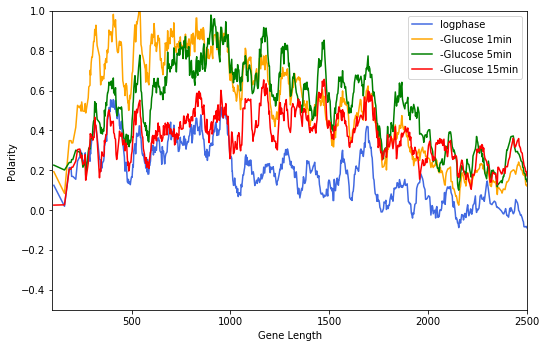

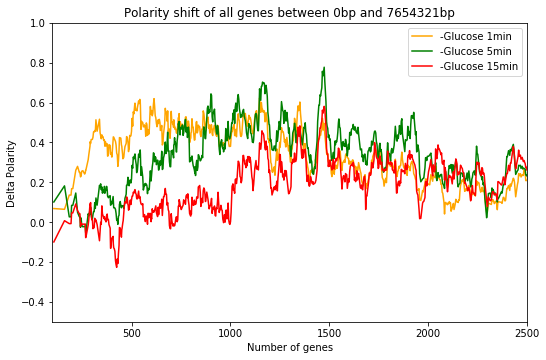

In [13]:
colors = ['royalblue','orange','green','red','violet','purple']

fig = plt.figure()
ax1 = plt.axes()
#for i in range(2,len(times)):
for i in range(len(times)):
    y = df_samples[times[i]]
    #y = df_samples[times[i]]-df_samples[times[0]]
    ax1.plot(df_samples.index, y,label=times[i],color=colors[i])
plt.xlim(100,2500)
plt.ylim(-0.5,1)
fig.set_size_inches(8.5, 5.5, forward=True)
#plt.title("Polarity of " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Gene Length")
plt.ylabel("Polarity")
plt.legend()
fig.savefig(cwd+'Polarity_length_readd_'+str(d1)+str(d2)+dhh1_tag+'.png', dpi =500)

fig = plt.figure()
ax1 = plt.axes()
#for i in range(3,len(times)):
for i in range(1,len(times)):
    y = (df_samples[times[i]]-df_samples[times[0]])
    ax1.plot(df_samples.index,y,label=times[i],color=colors[i])
plt.xlim(100,2500)
plt.ylim(-0.5,1)
fig.set_size_inches(8.5, 5.5, forward=True)
plt.title("Polarity shift of " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Number of genes")
plt.ylabel("Delta Polarity")
plt.legend()
fig.savefig(cwd+'Delta_Polarity_length_readd_'+str(d1)+str(d2)+dhh1_tag+'.png',dpi =500)


In [5]:
keys = []
values_list = []
fit_list = []
times = []
df_samples = pd.DataFrame()
num_c = 15
for i in range(len(polcsv_list)):
    file = polcsv_list[i]
    time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split('.csv')[0])) 
    label = labels[names.index(time)]
    print(label)
    times.append(label)
    df = pd.read_csv(file)
    df = df[(df.Name.isin(namelist))]
    df = df.set_index('Name')
    print(df.columns)
    if len(df_samples) == 0:
        df_samples = df_dhh1_all[['Code','Delta_Dhh1']]
    df_samples = pd.merge(df_samples, df[['PolarityPerGene']], left_index=True, right_index=True)
    df_samples = df_samples.rename(columns={"PolarityPerGene": label})
    
    
    

logphase
Index(['Unnamed: 0', 'Length', 'Counts', 'PolarityPerGene'], dtype='object')
-Glucose 7.5min
Index(['Unnamed: 0', 'Length', 'Counts', 'PolarityPerGene'], dtype='object')
-Glucose 15min
Index(['Unnamed: 0', 'Length', 'Counts', 'PolarityPerGene'], dtype='object')


In [22]:
df_samples['Delta_polarity_075'] = df_samples[times[1]] - df_samples[times[0]]
df_samples['Delta_polarity_15'] = df_samples[times[2]] - df_samples[times[1]]

In [23]:
df_samples = df_samples.sort_values(by=['Delta_Dhh1'])
low = df_samples.index.tolist()[:200]
mid = df_samples.index.tolist()[2000:2200]
high = df_samples.index.tolist()[-200:]

isred = []
for i in df_samples.index:
    if i in low:
        isred.append('low Dhh1')
    elif i in mid:
        isred.append('mid Dhh1')
    elif i in high:
        isred.append('high Dhh1')
    else:
        isred.append('v')
df_samples['Type'] = isred
#df_samples = df_samples.sort_values(by=['Type'])

In [73]:
fig = go.Figure()
cls = ['purple','orange','grey']
cs = ['high Dhh1','low Dhh1','mid Dhh1']
for i in range(3):
    colr = cs[i]
    fig.add_trace(go.Violin(x = df_samples['Type'][df_samples['Type'] == colr],
                            y=df_samples['Delta_polarity'][df_samples['Type'] == colr],
                            line_color=cls[i],
                            name=colr,
                            box_visible=True,
                            meanline_visible=True))
fig.update_layout(
    template='simple_white',
    #xaxis_title=xaxis_title,
    #yaxis_title=yaxis_title
)       

#fig.update_xaxes(range=[-2.5, 7])
fig.update_yaxes(range=[-1, 1.5])

fig.show()
fig.write_image(cwd+"/Dhh1_pol.png")

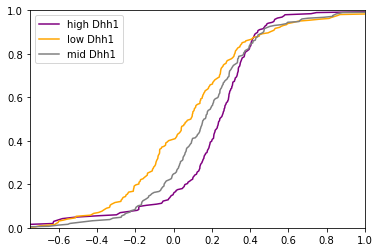

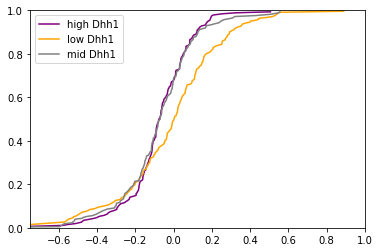

In [24]:
cls = ['purple','orange','grey']
cs = ['high Dhh1','low Dhh1','mid Dhh1']

fig = plt.figure()
for i in range(3):
    level = cs[i]
    col = cls[i]
    sub_df_samples = df_samples[df_samples['Type'] == level]
    sub_df_samples = sub_df_samples.sort_values(by=['Delta_polarity_075'])
    dhhs = sub_df_samples['Delta_Dhh1'].tolist()
    pol = sub_df_samples['Delta_polarity_075'].tolist()
    
    sum_dhh = sum(dhhs)
    cum_dhhs = []
    for j in range(len(dhhs)):
        perc = sum(dhhs[:j])/sum_dhh
        cum_dhhs.append(perc)
    plt.plot(pol,cum_dhhs,label=level,color=col)
plt.xlim(-0.75,1)
plt.ylim(0,1)
#fig.set_size_inches(8.5, 5.5, forward=True)
#plt.title("Polarity shift of " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
#plt.xlabel("Number of genes")
#plt.ylabel("Delta Polarity")
plt.legend()
fig.savefig(cwd+'/Dhh1_Pol_cumul_'+times[1]+'_.png',dpi =500)
cls = ['purple','orange','grey']
cs = ['high Dhh1','low Dhh1','mid Dhh1']

fig = plt.figure()
for i in range(3):
    level = cs[i]
    col = cls[i]
    sub_df_samples = df_samples[df_samples['Type'] == level]
    sub_df_samples = sub_df_samples.sort_values(by=['Delta_polarity_15'])
    dhhs = sub_df_samples['Delta_Dhh1'].tolist()
    pol = sub_df_samples['Delta_polarity_15'].tolist()
    
    sum_dhh = sum(dhhs)
    cum_dhhs = []
    for j in range(len(dhhs)):
        perc = sum(dhhs[:j])/sum_dhh
        cum_dhhs.append(perc)
    plt.plot(pol,cum_dhhs,label=level,color=col)
plt.xlim(-0.75,1)
plt.ylim(0,1)
#fig.set_size_inches(8.5, 5.5, forward=True)
#plt.title("Polarity shift of " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
#plt.xlabel("Number of genes")
#plt.ylabel("Delta Polarity")
plt.legend()
fig.savefig(cwd+'/Dhh1_Pol_cumul_'+times[2]+'_.png',dpi =500)


# Gene specifc polarity

In [37]:
times = []
for i in range(len(polcsv_list)):
    polfile = polcsv_list[i]
    time = ''.join(filter(lambda i: i.isdigit(), polfile.split('/')[-1].split('.csv')[0])) 
    label = labels[names.index(time)]
    print(label)
    times.append(label)
    df = pd.read_csv(polfile)
    df = df.set_index('Name')
    df = df[(df.index.isin(red))]
    for g in range(len(red)):
        gene = red[g]
        code = codes[g]
        color = col[g]
        print(code,df.loc[gene,'PolarityPerGene'])

logphase
HSP30 0.4039375424304141
PAB1 0.028153192393145905
PGK1 0.07942970839757027
HSP82 0.16615164759704185
HXK1 0.03175476800114856
GLC3 0.2527577284488629
-Glucose 7.5min
HSP30 -0.19659563194409946
PAB1 0.08120101973373611
PGK1 0.14547612752930164
HSP82 0.12859701381735847
HXK1 0.08161785984204638
GLC3 -0.235607040719052
-Glucose 15min
HSP30 0.05707386700216061
PAB1 0.13200238429915107
PGK1 0.13761725389001678
HSP82 0.11133011021098814
HXK1 0.056127378085168635
GLC3 -0.32182558753318763
